# Laboratorio #2 
## Multi-armed Bandit 
### CC3104 Reinforcement Learning 


>>> Strategy: greedy | Epsilon: None

>>> Strategy: epsilon_static | Epsilon: 0.01

>>> Strategy: epsilon_static | Epsilon: 0.05

>>> Strategy: epsilon_static | Epsilon: 0.1

>>> Strategy: epsilon_decay | Epsilon: 0.01

>>> Strategy: epsilon_decay | Epsilon: 0.05

>>> Strategy: epsilon_decay | Epsilon: 0.1


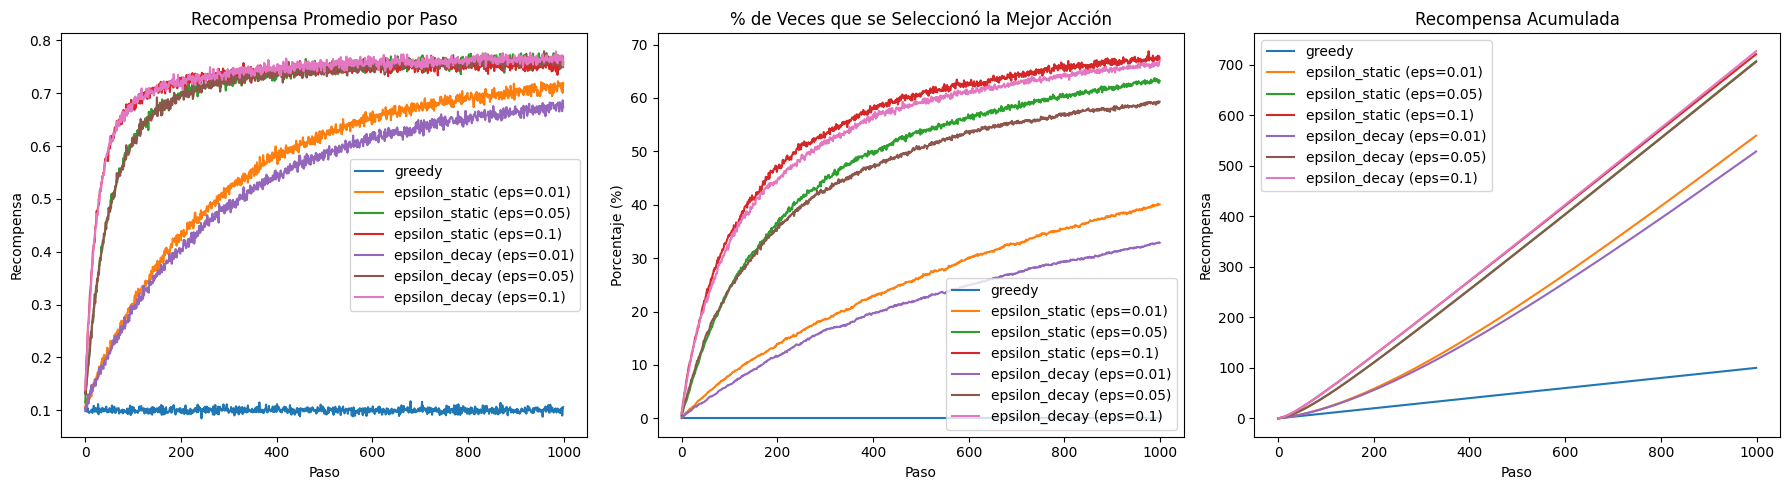

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

# Configuración general
probs = [0.10, 0.50, 0.60, 0.80, 0.10, 0.25, 0.60, 0.45, 0.75, 0.65] 
N_steps = 1000
N_experiments = 5000
save_fig = False  # Cambiar a True si deseas guardar las imágenes
output_dir = os.path.join(os.getcwd(), "output")

# --- Entorno ---
class Environment:
    def __init__(self, probs):
        self.probs = probs

    def step(self, action):
        return 1 if (np.random.random() < self.probs[action]) else 0

# --- Agente con estrategias múltiples ---
class Agent:
    def __init__(self, nActions, eps=0.1, strategy="greedy"):
        self.nActions = nActions
        self.eps = eps
        self.strategy = strategy
        self.total_steps = 0
        self.n = np.zeros(nActions, dtype=int)
        self.Q = np.zeros(nActions, dtype=float)

    def update_Q(self, action, reward):
        self.n[action] += 1
        self.Q[action] += (1.0 / self.n[action]) * (reward - self.Q[action])
        self.total_steps += 1

    def get_action(self):
        if self.strategy == "greedy":
            return np.argmax(self.Q)

        elif self.strategy == "epsilon_static":
            if np.random.rand() < self.eps:
                return np.random.randint(self.nActions)
            return np.argmax(self.Q)

        elif self.strategy == "epsilon_decay":
            epsilon = self.eps / (1 + self.total_steps / 1000)
            if np.random.rand() < epsilon:
                return np.random.randint(self.nActions)
            return np.argmax(self.Q)

        else:
            raise ValueError("Unknown strategy")

# --- Experimento para un agente ---
def experiment(probs, N_episodes, eps, strategy):
    env = Environment(probs)
    agent = Agent(len(env.probs), eps=eps, strategy=strategy)
    actions, rewards = [], []
    for episode in range(N_episodes):
        action = agent.get_action()
        reward = env.step(action)
        agent.update_Q(action, reward)
        actions.append(action)
        rewards.append(reward)
    return np.array(actions), np.array(rewards)

# --- Simulaciones para todas las configuraciones ---
strategies = ["greedy", "epsilon_static", "epsilon_decay"]
epsilons = [0.01, 0.05, 0.1]
results = {}

for strategy in strategies:
    for eps in epsilons if "epsilon" in strategy else [None]:
        print(f"\n>>> Strategy: {strategy} | Epsilon: {eps}")
        R = np.zeros((N_steps,))
        A = np.zeros((N_steps, len(probs)))
        for i in range(N_experiments):
            actions, rewards = experiment(probs, N_steps, eps if eps is not None else 0.0, strategy)
            R += rewards
            for j, a in enumerate(actions):
                A[j][a] += 1
        label = f"{strategy}" if eps is None else f"{strategy} (eps={eps})"
        results[label] = {
            "avg_rewards": R / N_experiments,
            "action_counts": A / N_experiments
        }

# --- Gráficas ---
plt.figure(figsize=(18, 5))

# Recompensa promedio
plt.subplot(1, 3, 1)
for label, data in results.items():
    plt.plot(data["avg_rewards"], label=label)
plt.title("Recompensa Promedio por Paso")
plt.xlabel("Paso")
plt.ylabel("Recompensa")
plt.legend()

# % de mejor acción
plt.subplot(1, 3, 2)
best_action = np.argmax(probs)
for label, data in results.items():
    pct_best_action = 100 * data["action_counts"][:, best_action]
    plt.plot(pct_best_action, label=label)
plt.title("% de Veces que se Seleccionó la Mejor Acción")
plt.xlabel("Paso")
plt.ylabel("Porcentaje (%)")
plt.legend()

# Recompensa acumulada
plt.subplot(1, 3, 3)
for label, data in results.items():
    plt.plot(np.cumsum(data["avg_rewards"]), label=label)
plt.title("Recompensa Acumulada")
plt.xlabel("Paso")
plt.ylabel("Recompensa")
plt.legend()

plt.tight_layout()
if save_fig:
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    plt.savefig(os.path.join(output_dir, "comparative_results.png"))
else:
    plt.show()

## Conclusiones del Laboratorio

### ¿Cuál de los algoritmos presenta mejor desempeño general?

Basándonos en las gráficas:

- El algoritmo **Epsilon-Greedy con decaimiento de epsilon (eps=0.1)** obtuvo el mejor desempeño general.
- Fue el que alcanzó:
  - **La mayor recompensa promedio por paso** (~0.75).
  - **La mayor tasa de selección de la mejor acción**, superando el 65% hacia el paso 1000.
  - **La mayor recompensa acumulada**, por encima de 700.
- Le sigue de cerca **Epsilon-Greedy estático (eps=0.1)**, aunque converge un poco más lento.

En contraste, la estrategia **Greedy pura (sin exploración)** tuvo el peor rendimiento en todas las métricas.

---

### ¿Cómo influye el valor de epsilon?

Los resultados muestran que:

- Un **epsilon bajo (0.01)**, ya sea estático o con decaimiento, explora muy poco. Esto limita el aprendizaje y puede llevar a decisiones subóptimas.
- Un **epsilon medio (0.05)** mejora la exploración y el rendimiento, pero sigue siendo superado por valores más altos.
- Un **epsilon alto (0.1)** permite una exploración adecuada, y cuando se combina con decaimiento, logra un equilibrio ideal: exploración inicial seguida de explotación.

---

### ¿Cuándo es mejor usar epsilon variable?

La estrategia de **epsilon decaído** es particularmente útil cuando:

- Se requiere **explorar bastante al inicio**, para identificar qué acciones son efectivas.
- Se desea luego **reducir la exploración** para centrarse en la mejor acción conocida.
- El entorno es estacionario (las recompensas no cambian), permitiendo una explotación segura después de una fase de aprendizaje.

---

### Conclusión general

- **Epsilon-Greedy con decaimiento (eps=0.1)** es la mejor estrategia para este entorno.
- Combina exploración eficiente con explotación óptima a largo plazo.
- La estrategia greedy (sin exploración) **no es recomendable** en problemas con incertidumbre, ya que no permite descubrir nuevas opciones potencialmente mejores.